In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, RSTDP_INH_SEASONAL, AbstractSeasonalLearning
from libs.second_appr_simp_t2 import CorticalColumn, LayerConnection, ComplexStructure, load, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence, RandomConnection, get_output_size_maxpool1d
from libs.network import MultiConnectionNetwork

In [2]:
seed = random.randint(0,9999999)
print(seed)

848518


In [3]:
# seed = 1400
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

# Prepare Inputs

In [4]:
input_size_c1 = 200
input_size_c2 = 200
each_session = 40
session_number = 500
# layer23_involve_from = 500
gap_time = 20

time = session_number * each_session
spike_train_c1 = torch.zeros(time, input_size_c1).bool()
spike_train_c2 = torch.zeros(time, input_size_c2).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
# session_class = torch.tensor(([True, False] * int((session_number + 1) / 2))[:session_number])

active_fire_rate = 0.2


pattern_size = int(input_size_c1/2)
for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size_c1) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train_c1[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train_c1[idx * each_session: (idx + 1) * each_session, :int(input_size_c1/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train_c1[idx * each_session: (idx + 1) * each_session, int(input_size_c1/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls
    
pattern_size = int(input_size_c2/2)
for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size_c2) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train_c2[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train_c2[idx * each_session: (idx + 1) * each_session, :int(input_size_c2/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train_c2[idx * each_session: (idx + 1) * each_session, int(input_size_c2/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

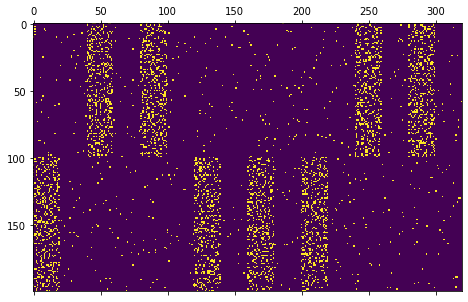

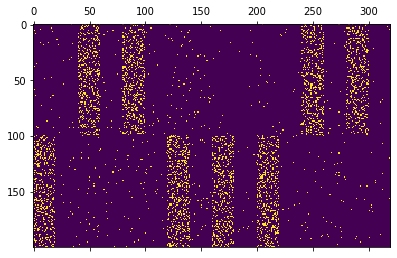

In [5]:
import matplotlib.pyplot as plt

plt.matshow(spike_train_c1.T[:, :8 * each_session])
plt.matshow(spike_train_c2.T[:, :8 * each_session])

# Load Models

In [6]:
c1_complex = load('models/c1.pt')
c2_complex = load('models/c2.pt')

In [7]:
c1 = c1_complex.submodules[0]
c2 = c2_complex.submodules[0]

In [8]:
c1.disable_learning()
c2.disable_learning()

# Create Model

In [9]:
connection_args = { # Between Layer
    'kernel_size': 5,
    'stride': 3,
    'weight': 16,
}
layer_args_l23 = {
    'exc_size': get_output_size_maxpool1d(100, 5, 3),
    'inh_con_args': { # Inside Layer
        'wmin': -3.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 1.0,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 15,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
    }
}
layer_args_l4 = {
    'exc_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -2.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.30,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 6,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
    }
}
input_to_cc_con_args = {
    'wmin': 0.,
    'wmax': 1.0,
    'nu': [0.03, 0.01],
#     'update_rule': PostPre,
    'probability': 0.50,
    
    'update_rule': MSTDPET_SEASONAL,
    'tc_plus': 10,
    'tc_minus': 10, 
    'tc_e_trace': 10,
}
backward_args_kw = {
    'backward': True,
    'backward_exc_args': {
        'potential_percent': torch.distributions.beta.Beta(3, 80),  # ("random", 0.1, 0.7),
        'connection_rate': 0.2,
        'before_computation_delay': 0,
        'update_rule': RSTDP_SEASONAL,
        'direct_voltage_manipulation': True,
        'wmin': 0.,
        'wmax': 0.95,
        'nu': [0.003, 0.007],
        'enable': True,

        'weight_decay': 0.00005,
        'tc_plus': 6,
        'tc_minus': 6, 
        'tc_e_trace': 6,
    },
    'backward_inh_args': {
        'potential_percent': torch.distributions.beta.Beta(3, 80),  # ("random", 0.1, 0.7),
        'connection_rate': 0.2,
        'before_computation_delay': 0,
        'update_rule': RSTDP_INH_SEASONAL,
        'direct_voltage_manipulation': True,
        'wmin': -0.95,
        'wmax': 0,
        'nu': [0.007, 0.003],
        'enable': True,
        'behavior': 'inh',

        'windows_size': 5,
        'windows_std': 0.5,
        'weight_decay': 0.00005,
        'tc_plus': 6,
        'tc_minus': 6, 
        'tc_e_trace': 6,
    }
}
connection_type = RandomConnection

In [10]:
c3 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, name="c3", monitor=LAYER_23|LAYER_4, **backward_args_kw)

In [11]:
c1_c3_connection = LayerConnection(c1_complex, c3, connection_type, input_to_cc_con_args)
c2_c3_connection = LayerConnection(c2_complex, c3, connection_type, input_to_cc_con_args)
# TODO: add backwards

In [12]:
c2_c3_connection.connections

[('c2_l23__exc1',
  'c3_l4__exc1',
  RandomConnection(
    (source): LIFNodes()
    (target): LIFNodes()
  )),
 ('c2_l23__exc1',
  'c3_l4__exc2',
  RandomConnection(
    (source): LIFNodes()
    (target): LIFNodes()
  )),
 ('c2_l23__exc2',
  'c3_l4__exc1',
  RandomConnection(
    (source): LIFNodes()
    (target): LIFNodes()
  )),
 ('c2_l23__exc2',
  'c3_l4__exc2',
  RandomConnection(
    (source): LIFNodes()
    (target): LIFNodes()
  ))]

In [13]:
model = ComplexStructure()
model.add_submodule(c1_complex)
model.add_submodule(c2_complex)
model.add_submodule(c3)
model.add_submodule(c1_c3_connection)
model.add_submodule(c2_c3_connection)
model.add_outpops_feedforward(c3.get_feedforward_output_pops())
model.add_inpops_backward(c3.get_backward_input_pops())

# Add to Network

In [14]:
network = MultiConnectionNetwork(dt=1.0)
model.add_to_network(network)

In [15]:
bl_monitors = []
bl_monitors_name = []
for a, b, con in c1_c3_connection.connections + c2_c3_connection.connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    bl_monitors_name.append((a, b))
    

# Run Network

In [16]:
from tqdm import trange

rewards = []
changes = []
activities = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):

#     if part == layer23_involve_from:
#         c3.l4.disable_learning()
#         input_to_c1_connection.disable_learning()
        
#         c3.l23.enable_learning()
#         c3.l4_l23.enable_learning()
        
        
    inp = {
        'input_c1': spike_train_c1[part*each_session:part*each_session+each_session, :],
        'input_c2': spike_train_c2[part*each_session:part*each_session+each_session, :],
    }
    network.run(inputs=inp, time=each_session)
    
    avg_sessions = 10
    in_use_sessions = min(part + 1, avg_sessions)
    exc1_avg = c3.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    exc2_avg = c3.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    
    exc1_act = c3.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()# - exc1_avg
    exc2_act = c3.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()# - exc2_avg
    
    activities.append((exc1_act, exc2_act))
    
    pattern = session_class[part]
    gap = abs(exc2_act - exc1_act) / layer_args_l23['exc_size']  #  In Range 0-1
    gap_check = abs(exc2_act - exc1_act) / layer_args_l23['exc_size'] > 0.3
    
    exc1_wins = exc1_act > exc2_act
    
    if pattern == exc1_wins and gap_check:
        reward = 1.0 + gap
    elif pattern == exc1_wins:
        reward = -0.5 + gap
    else:
        reward = -1 - gap
        
    rewards.append(reward)
    
    for conn in c1_c3_connection.connections + c2_c3_connection.connections:
        if isinstance(conn[2].update_rule, AbstractSeasonalLearning):
            change = conn[2].update_rule.trigger(reward)
            changes.append(change)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:47<00:00,  2.20parts/s]


In [17]:
rewards

[tensor(-4.0938),
 tensor(3.4375),
 tensor(4.4062),
 tensor(-3.6250),
 tensor(2.9688),
 tensor(4.8750),
 tensor(2.1250),
 tensor(4.4375),
 tensor(3.7188),
 tensor(4.9375),
 tensor(4.9688),
 tensor(3.5312),
 tensor(4.5625),
 tensor(4.7500),
 tensor(5.),
 tensor(4.),
 tensor(5.),
 tensor(4.),
 tensor(5.),
 tensor(4.2812),
 tensor(3.9688),
 tensor(4.8438),
 tensor(5.),
 tensor(5.0938),
 tensor(4.0625),
 tensor(3.9375),
 tensor(3.9375),
 tensor(3.3438),
 tensor(3.5312),
 tensor(5.),
 tensor(5.1250),
 tensor(5.),
 tensor(5.),
 tensor(3.5625),
 tensor(5.),
 tensor(5.),
 tensor(5.),
 tensor(3.9062),
 tensor(5.0625),
 tensor(4.),
 tensor(5.),
 tensor(3.8750),
 tensor(3.6875),
 tensor(4.9375),
 tensor(3.8750),
 tensor(5.),
 tensor(3.9062),
 tensor(3.9688),
 tensor(5.),
 tensor(3.7812),
 tensor(3.7188),
 tensor(4.),
 tensor(5.),
 tensor(5.),
 tensor(5.),
 tensor(5.),
 tensor(3.4062),
 tensor(5.),
 tensor(5.),
 tensor(5.),
 tensor(3.7500),
 tensor(3.8750),
 tensor(-3.9688),
 tensor(4.7188),
 tens

# Analysis

In [18]:
time_show = time

In [19]:
spikes = {
    "C1 Output | 1": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C1 Output | 2": c1.l23.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "C2 Output | 1": c2.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C2 Output | 2": c2.l23.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L4 | 1": c3.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L4 | 2": c3.l4.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L23 | 1": c3.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L23 | 2": c3.l23.monitors[1][1].get('s')[-time_show:,0,:].T,
}

## Convergence

('c1_l23__exc1', 'c3_l4__exc1')
('c1_l23__exc1', 'c3_l4__exc2')
('c1_l23__exc2', 'c3_l4__exc1')
('c1_l23__exc2', 'c3_l4__exc2')
('c2_l23__exc1', 'c3_l4__exc1')
('c2_l23__exc1', 'c3_l4__exc2')
('c2_l23__exc2', 'c3_l4__exc1')
('c2_l23__exc2', 'c3_l4__exc2')


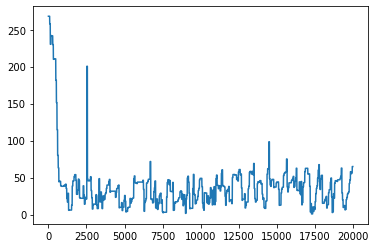

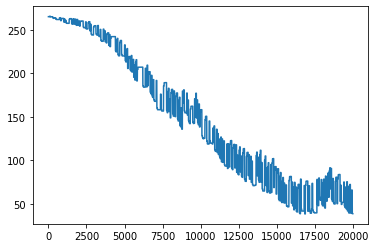

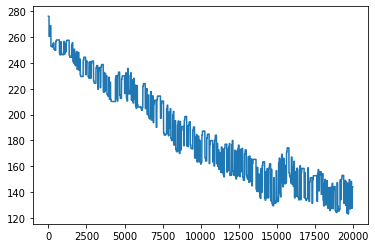

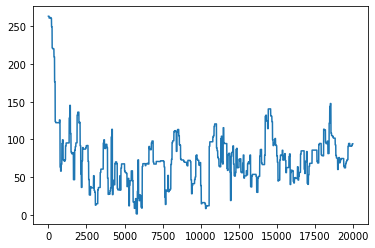

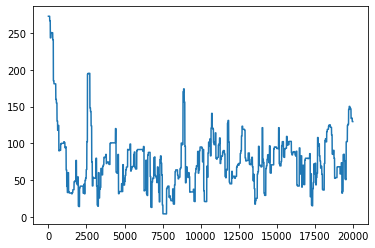

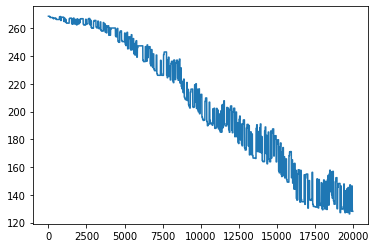

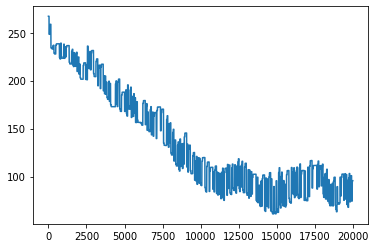

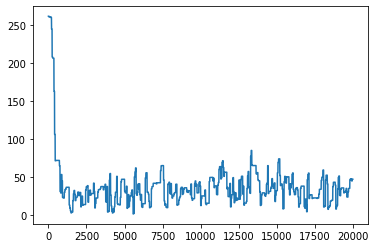

In [20]:
for name, m in zip(bl_monitors_name, bl_monitors):
    print(name)
    plt.figure()
    plt.plot(m.get('converge'))

## Confusion

### Layer 4

In [21]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    260.8461608886719
L4 -- Excitatory 1 -- Pattern 2     :    4.708333492279053
L4 -- Excitatory 2 -- Pattern 1     :    1.576923131942749
L4 -- Excitatory 2 -- Pattern 2     :    222.25


In [22]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    259.89654541015625
L4 -- Excitatory 1 -- Pattern 2     :    4.095238208770752
L4 -- Excitatory 2 -- Pattern 1     :    1.4482758045196533
L4 -- Excitatory 2 -- Pattern 2     :    221.64285278320312


In [23]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    334.5855407714844
L4 -- Excitatory 1 -- Pattern 2     :    3.6666667461395264
L4 -- Excitatory 2 -- Pattern 1     :    0.8707224130630493
L4 -- Excitatory 2 -- Pattern 2     :    324.4008483886719


### Layer 2,3

In [24]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    85.92308044433594
L4 -- Excitatory 1 -- Pattern 2     :    1.875
L4 -- Excitatory 2 -- Pattern 1     :    0.07692307978868484
L4 -- Excitatory 2 -- Pattern 2     :    71.45833587646484


In [25]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    87.17241668701172
L23 -- Excitatory 1 -- Pattern 2     :    1.0714285373687744
L23 -- Excitatory 2 -- Pattern 1     :    0.03448275849223137
L23 -- Excitatory 2 -- Pattern 2     :    72.95237731933594


In [26]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    111.50570678710938
L23 -- Excitatory 1 -- Pattern 2     :    1.4641350507736206
L23 -- Excitatory 2 -- Pattern 1     :    0.14828898012638092
L23 -- Excitatory 2 -- Pattern 2     :    107.63713073730469


## Pattern Separation

In [27]:
c1_c3_connection.submodules

[]

In [28]:
for source, target, connection in c1_c3_connection.connections + c2_c3_connection.connections:
    print(f"{source}  --->   {target}   :   {connection.w.sum()}")

c1_l23__exc1  --->   c3_l4__exc1   :   1512.9976806640625
c1_l23__exc1  --->   c3_l4__exc2   :   130.09530639648438
c1_l23__exc2  --->   c3_l4__exc1   :   340.8444519042969
c1_l23__exc2  --->   c3_l4__exc2   :   1541.1265869140625
c2_l23__exc1  --->   c3_l4__exc1   :   1306.252197265625
c2_l23__exc1  --->   c3_l4__exc2   :   365.3911437988281
c2_l23__exc2  --->   c3_l4__exc1   :   142.2561492919922
c2_l23__exc2  --->   c3_l4__exc2   :   1834.69970703125


In [29]:
# for source, target, connection in c1.l4_l23.connections:
#     print(f"{source}   --->   {target}   :   {connection.w.sum()}")

## Activities

In [30]:
# x = 3
# plt.matshow(spike_train_c1.T[:, x * each_session:x * each_session + each_session])
# plt.matshow(spike_train_c2.T[:, x * each_session:x * each_session + each_session])

In [31]:
def show_spikes(time, spikes_name, fig_size=(10,14)):
    nos = len(spikes_name)
    x = time
    fig, axs = plt.subplots(1, nos, figsize=fig_size)
    for name, ax in zip(spikes_name, axs):
        ax.matshow(spikes[name][:, x * each_session:x * each_session + each_session])
        ax.set_title(name)
    fig.suptitle(f'Spikes in range {x * each_session}ms - {x * each_session + each_session}ms')

In [32]:
x = session_number - 1

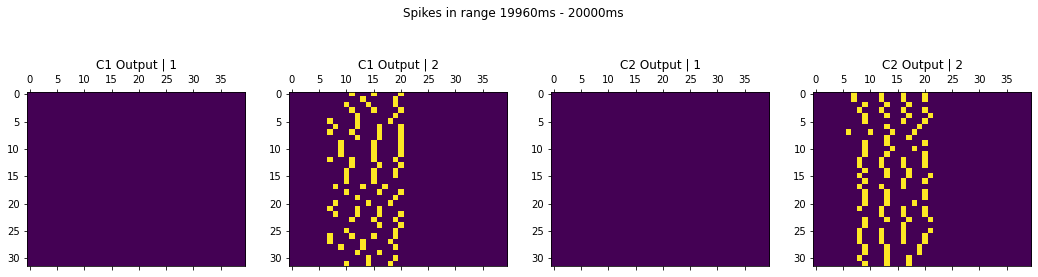

In [33]:
show_spikes(x, ["C1 Output | 1", "C1 Output | 2", "C2 Output | 1", "C2 Output | 2"], fig_size=(18,5))

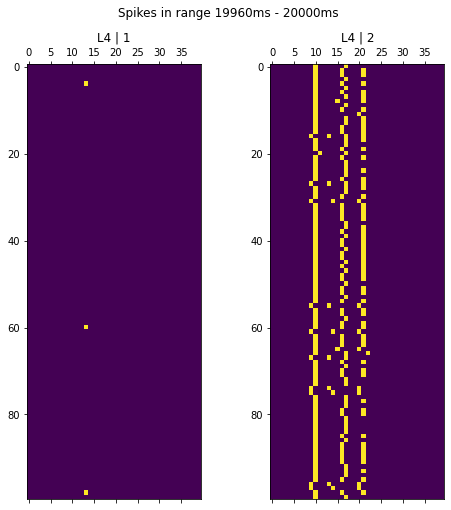

In [34]:
show_spikes(x, ["L4 | 1", "L4 | 2"], fig_size=(8,8))

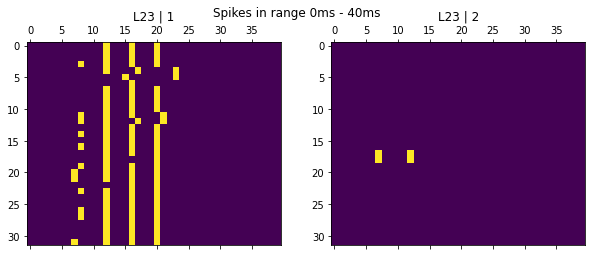

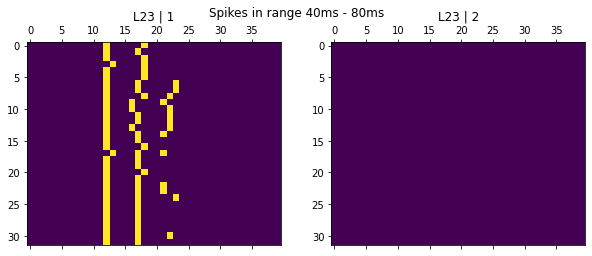

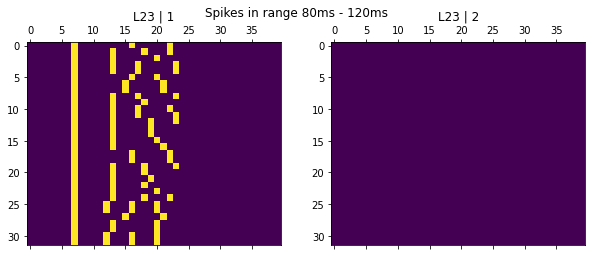

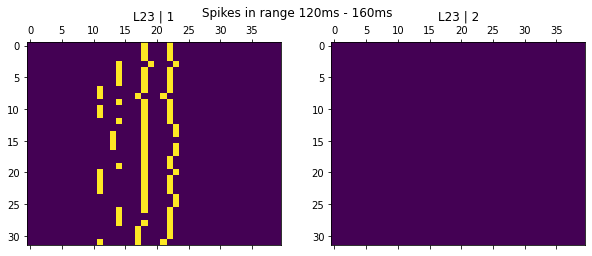

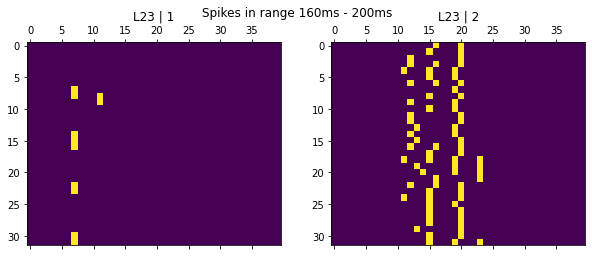

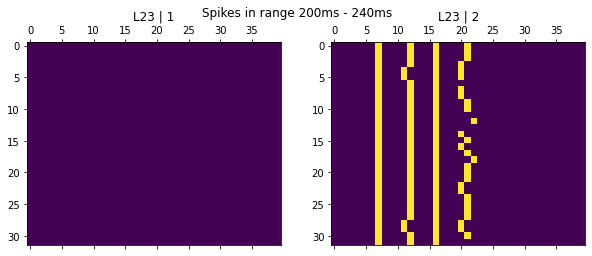

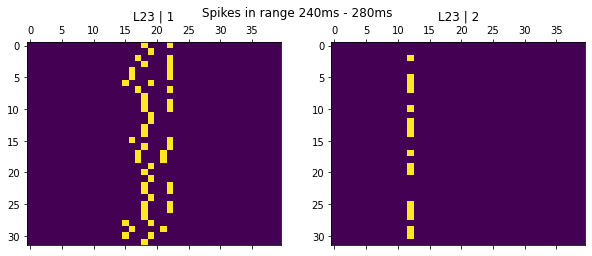

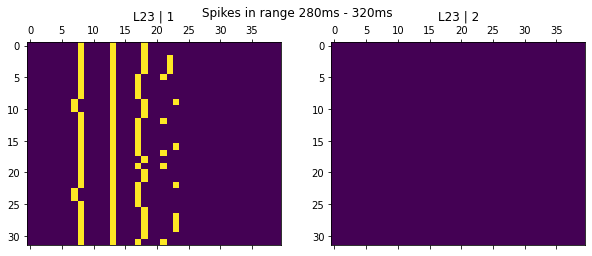

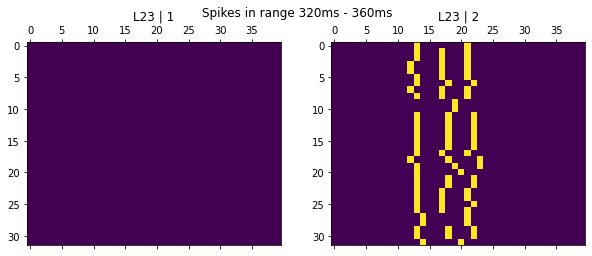

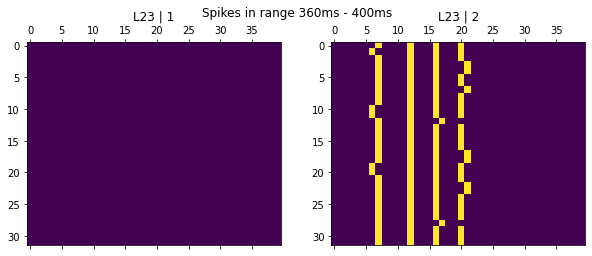

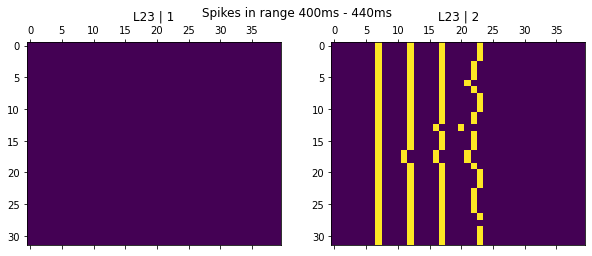

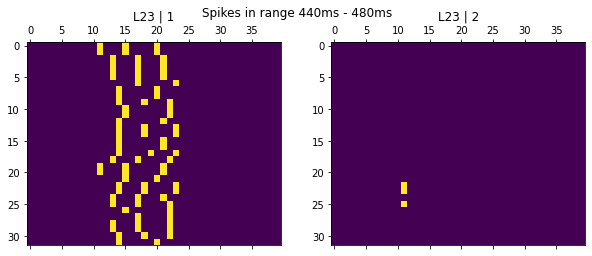

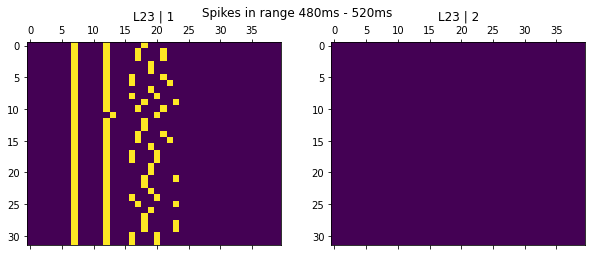

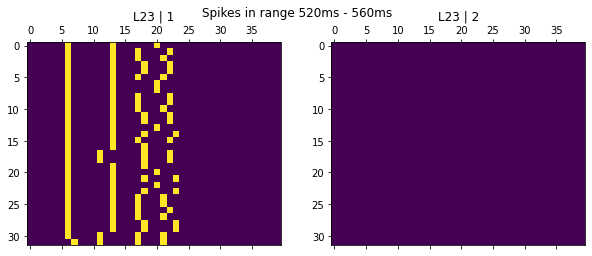

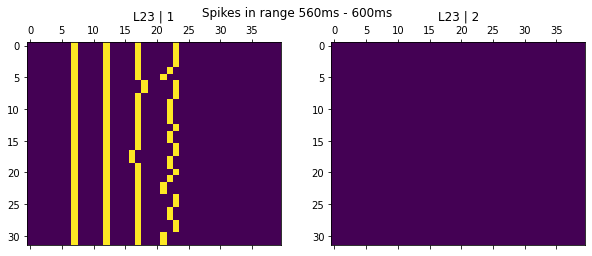

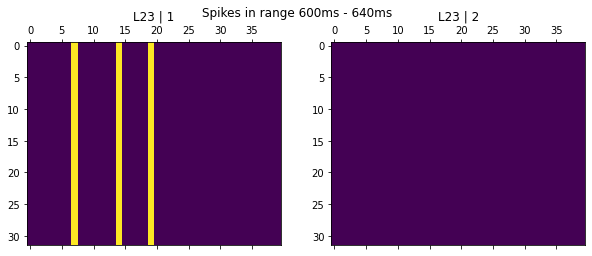

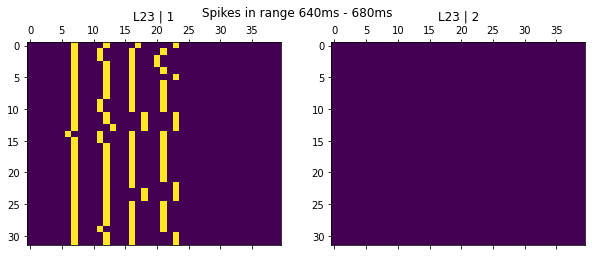

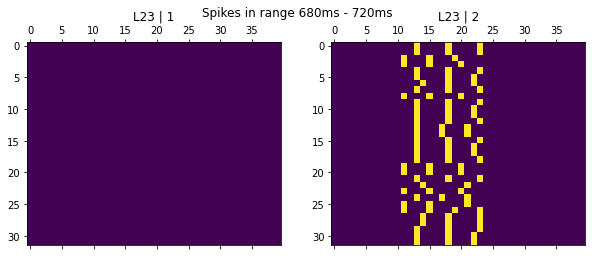

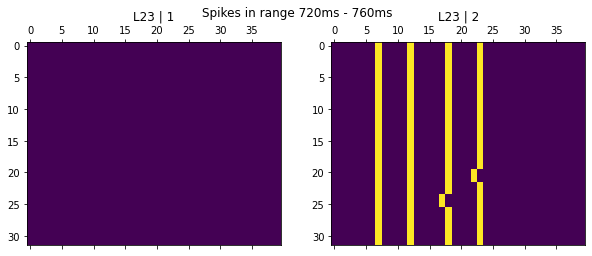

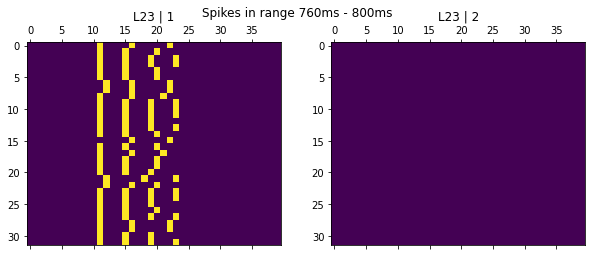

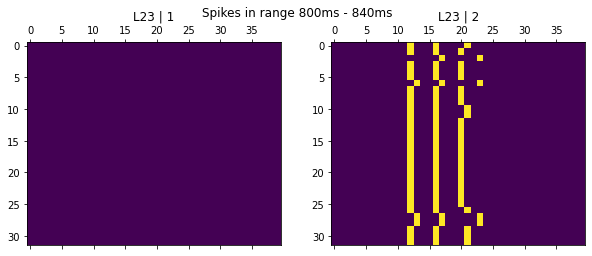

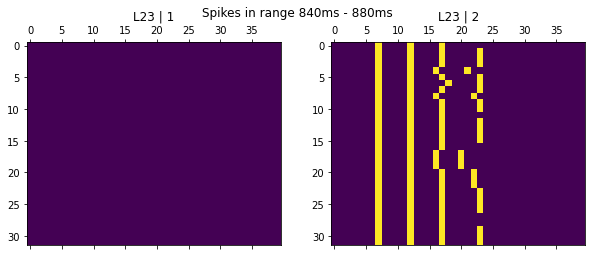

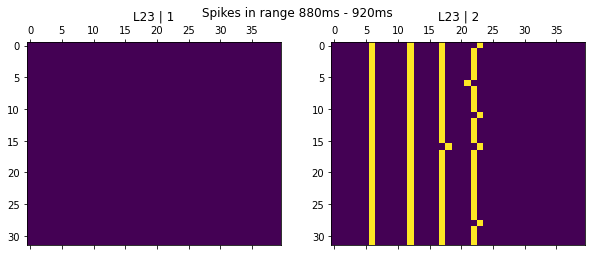

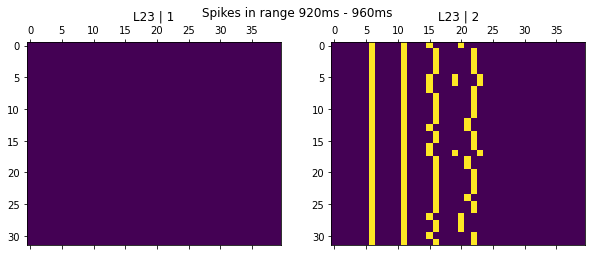

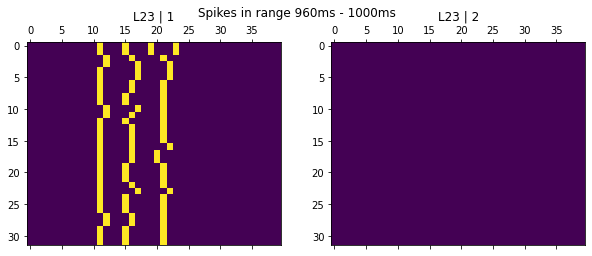

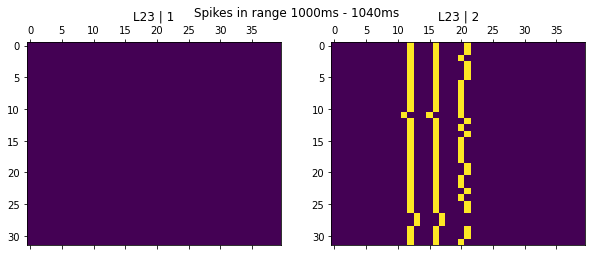

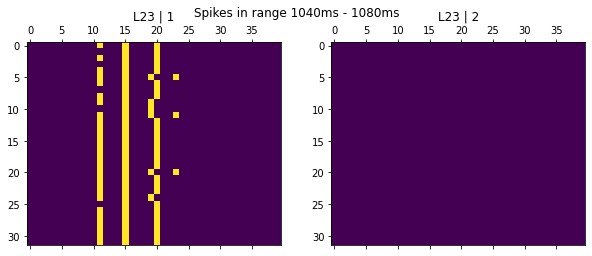

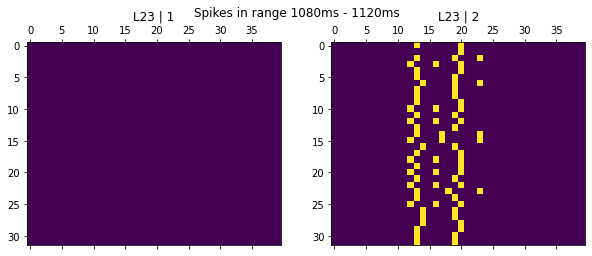

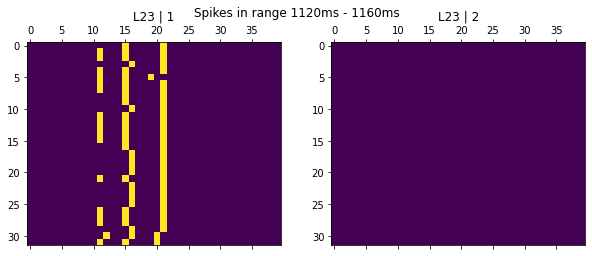

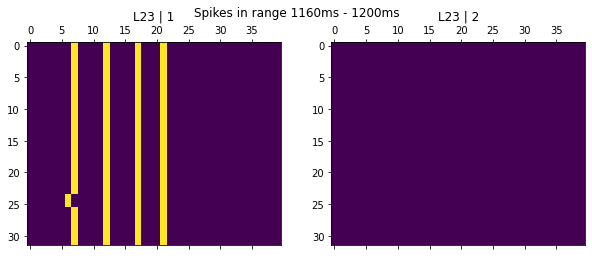

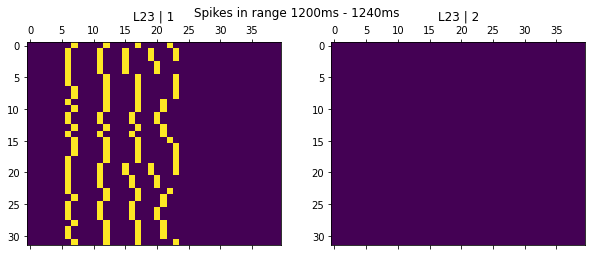

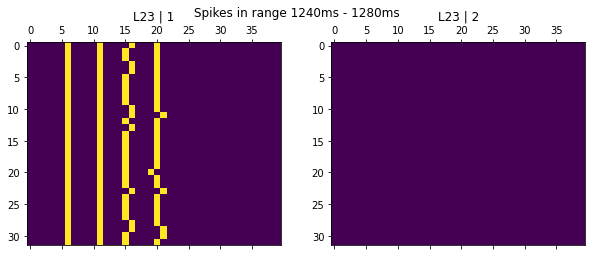

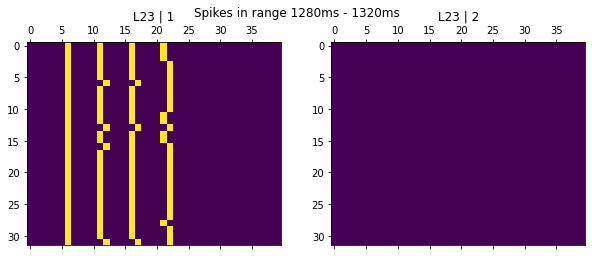

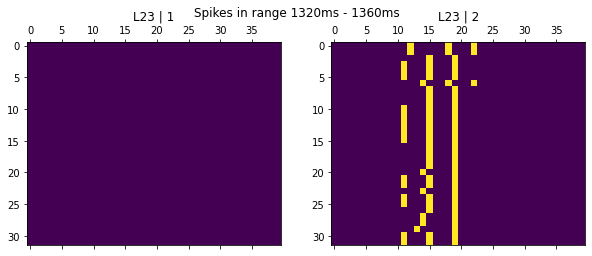

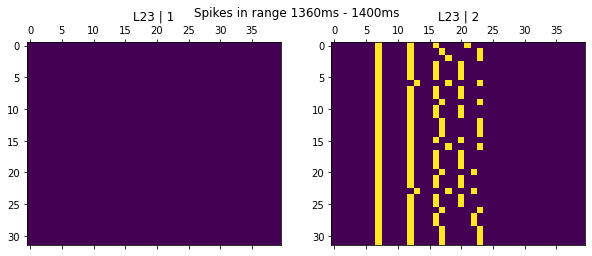

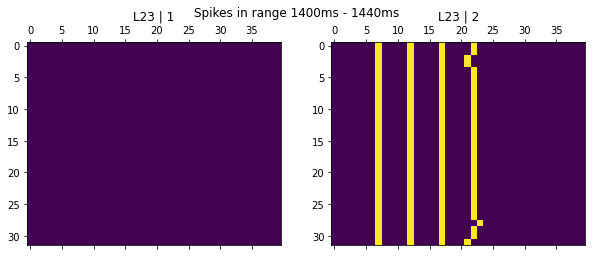

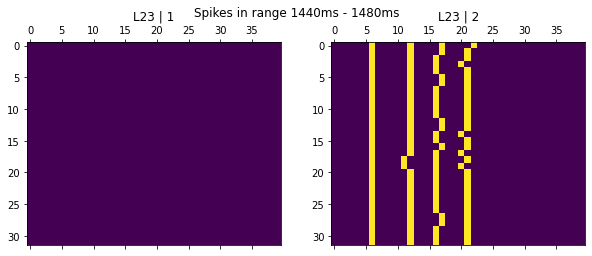

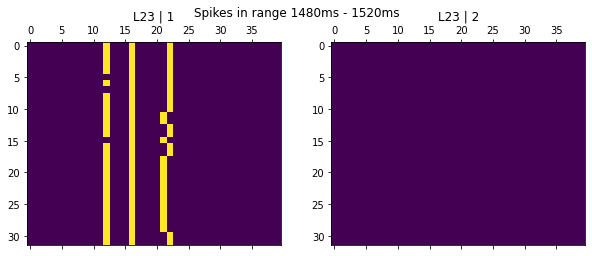

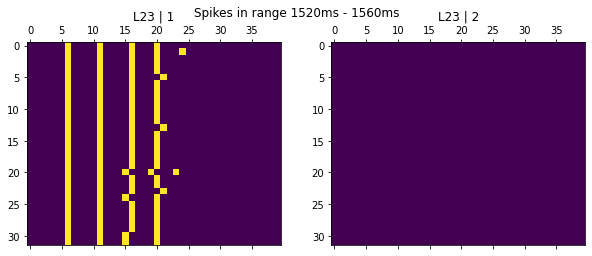

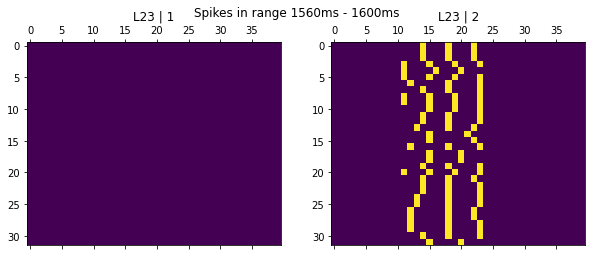

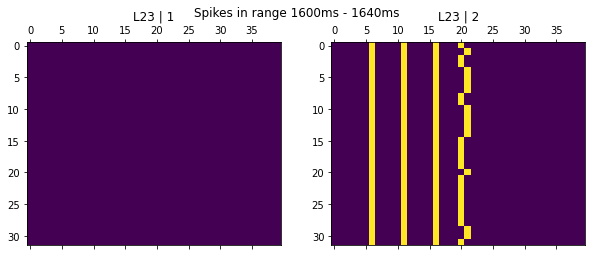

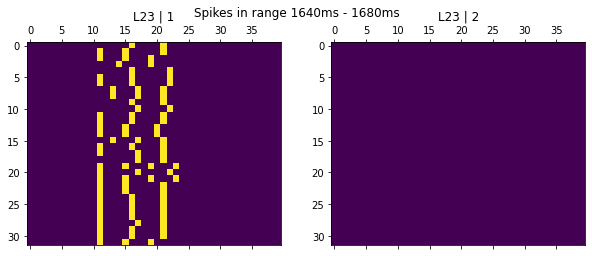

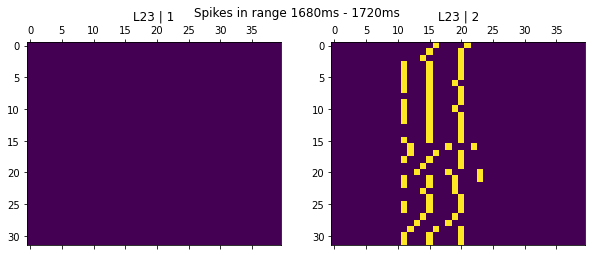

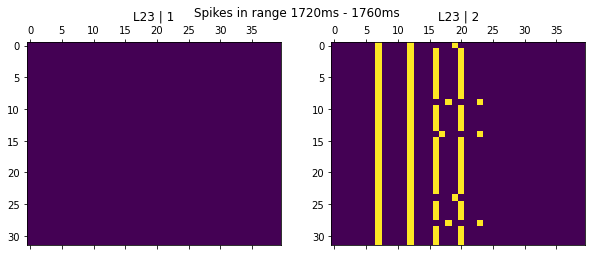

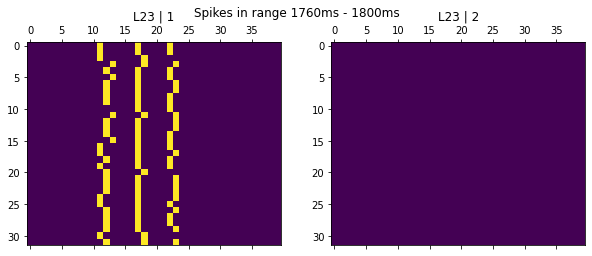

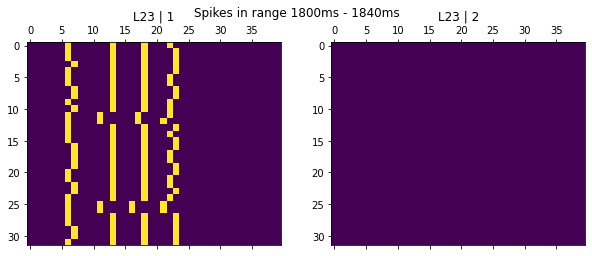

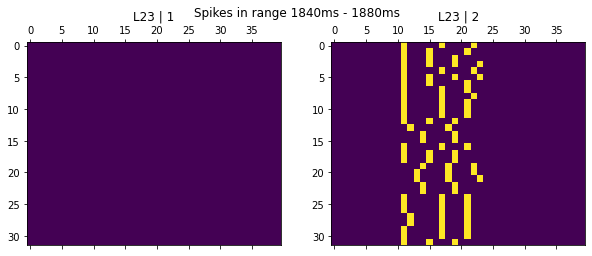

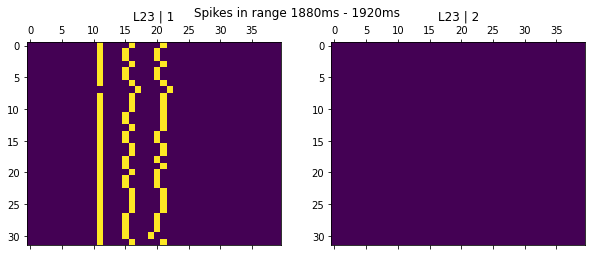

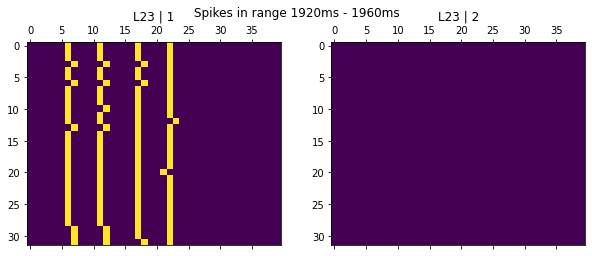

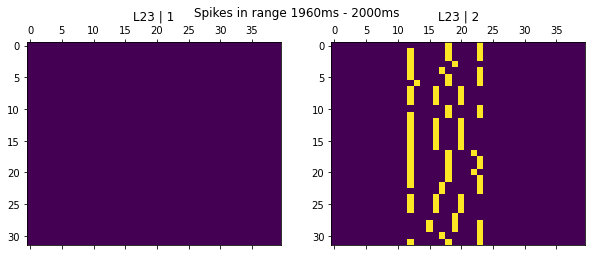

In [35]:
# print(session_class[x])
# plt.matshow(spikes["L23 | 1"][:, x * each_session:x * each_session + each_session])
# plt.matshow(spikes["L23 | 2"][:, x * each_session:x * each_session + each_session])
for x in range(0, 50):
    show_spikes(x, ["L23 | 1", "L23 | 2"], fig_size=(10,4))

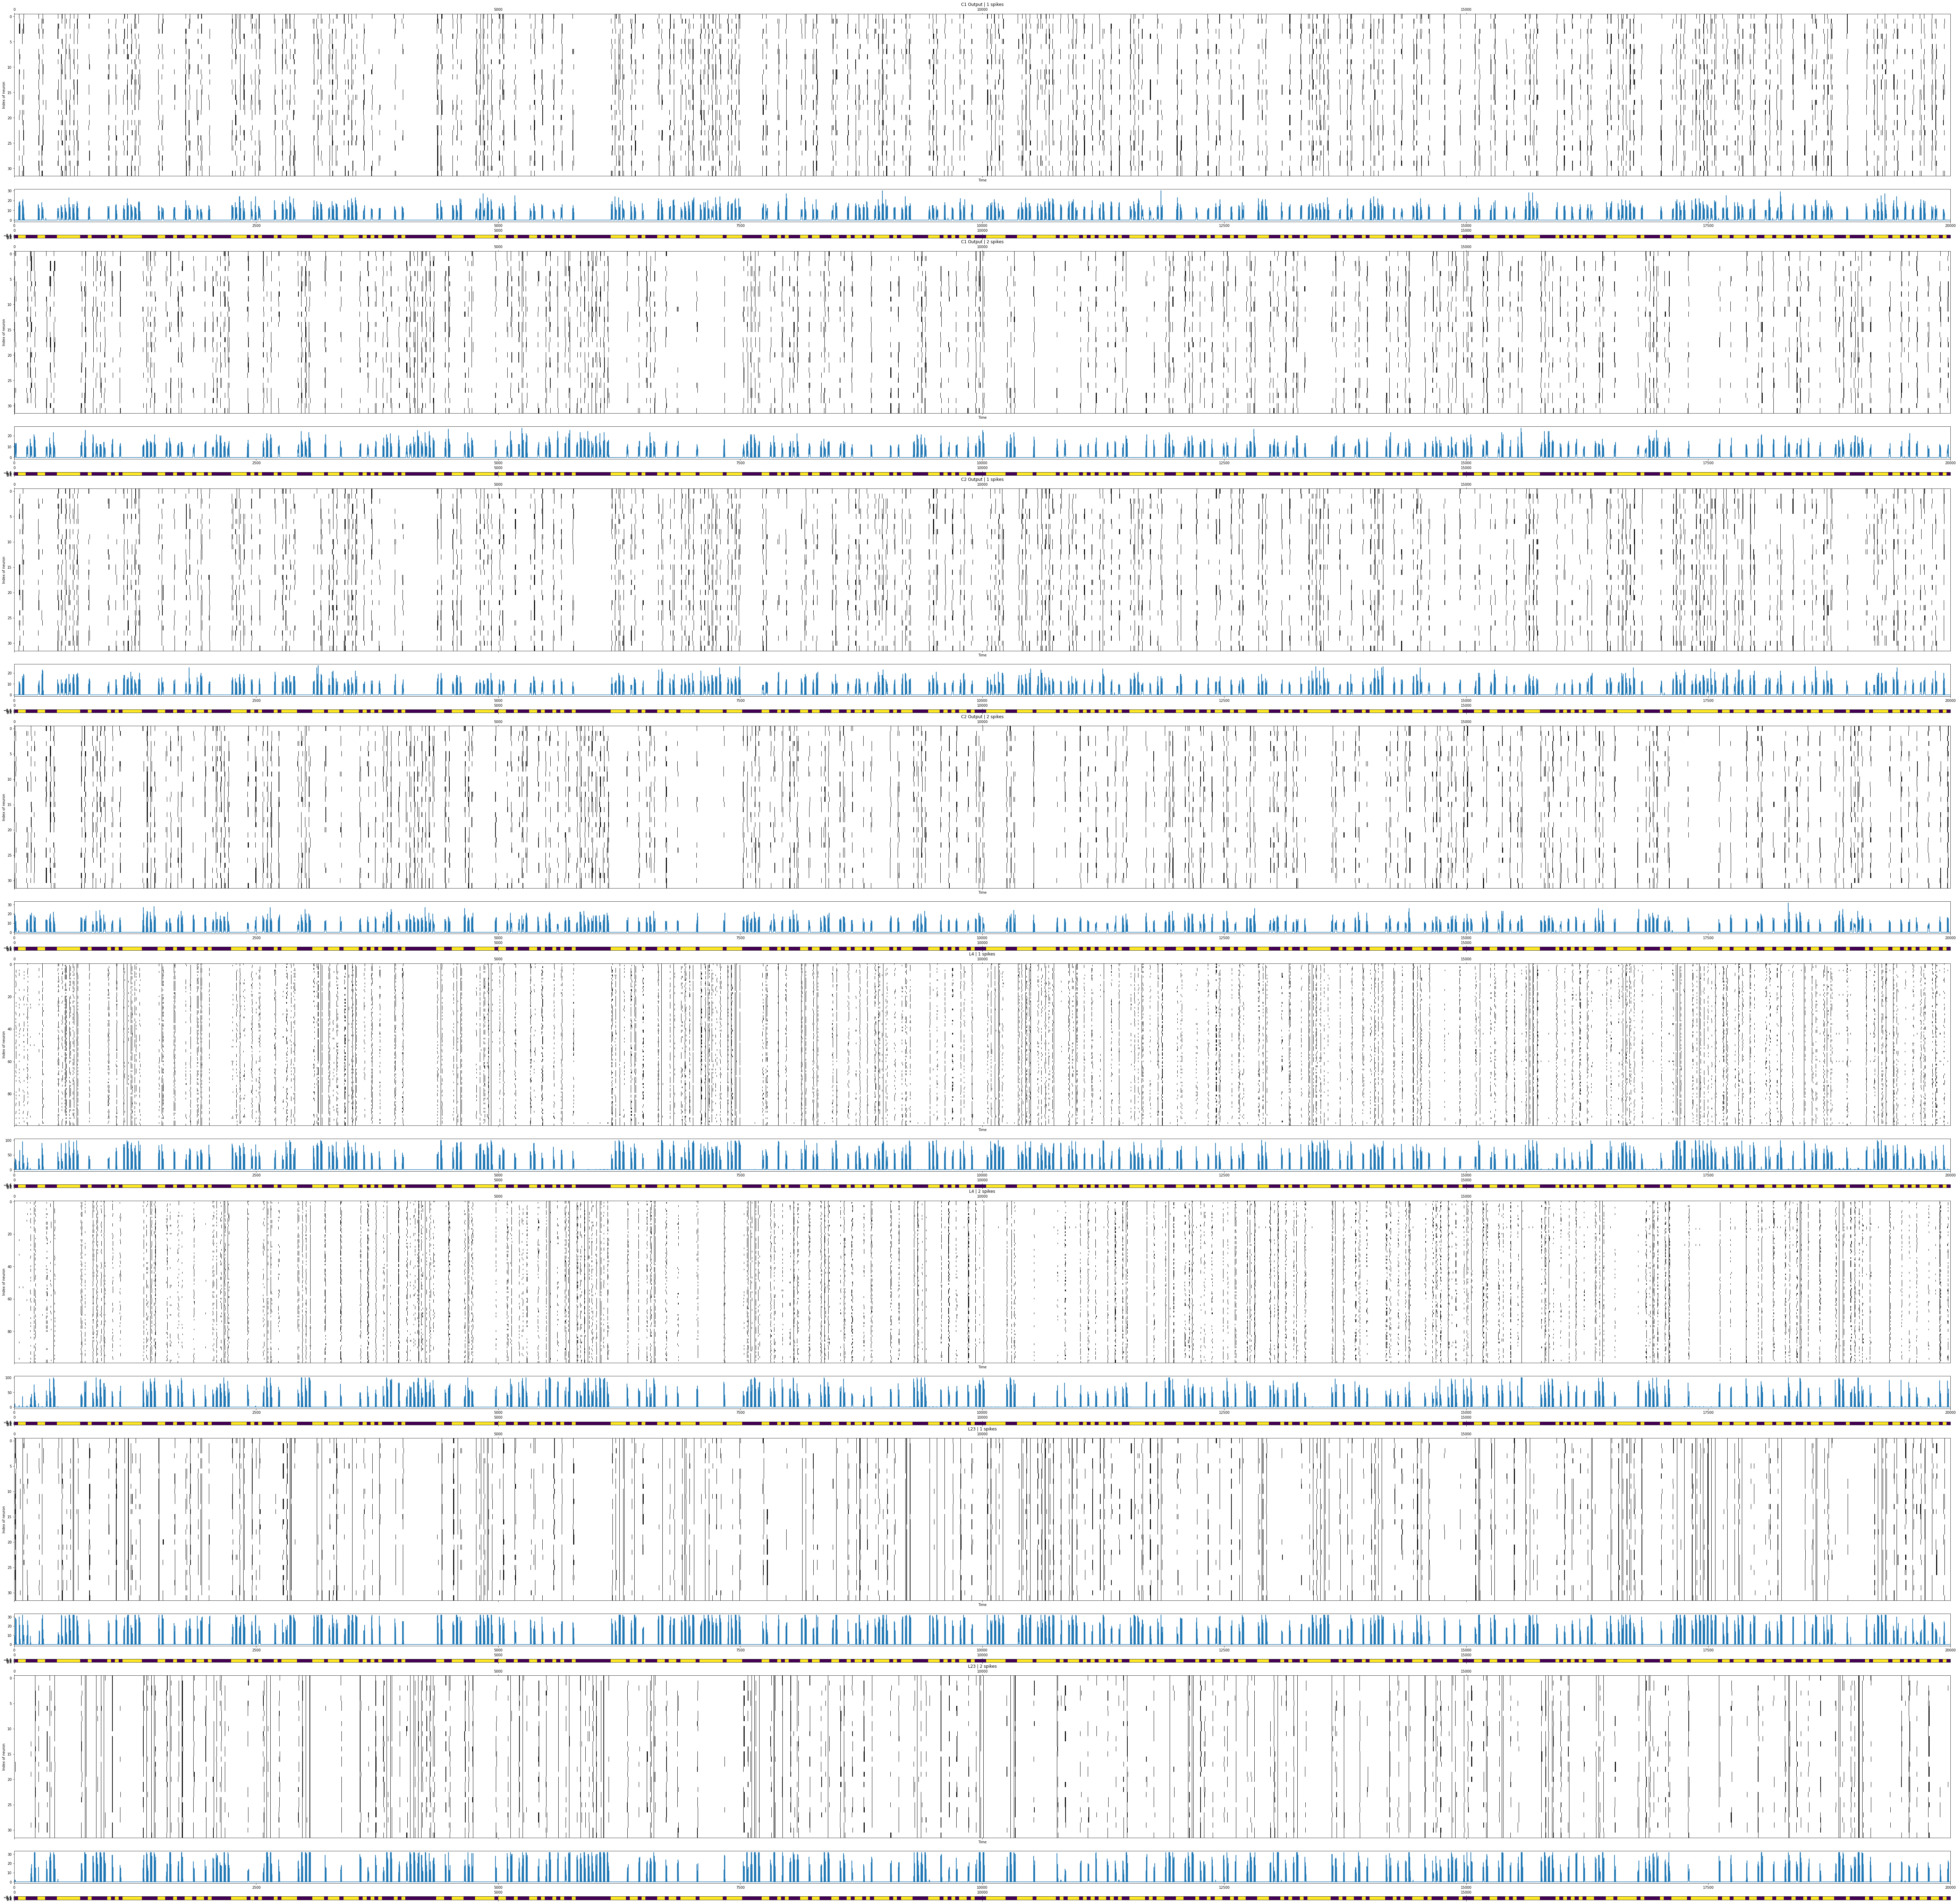

In [36]:
ver_num = len(spikes)
fig, axes = plt.subplots(ver_num * 3, 1, figsize=(100, 100), gridspec_kw={'height_ratios': [50, 10, 1] * ver_num})
# fig.suptitle(f"Spikes: t={start_time}-{end_time}")
for idx, layer in enumerate(spikes):
    indx = idx * 3
    axes[indx].matshow(spikes[layer], cmap='Greys')
    axes[indx].set_title('%s spikes' % layer)
    axes[indx].set_xlabel('Time')
    axes[indx].set_ylabel('Index of neuron')
    axes[indx].set_aspect('auto')
    
    activity = spikes[layer].sum(0)
    axes[indx + 1].plot(activity)
    axes[indx + 1].set_aspect('auto')
    axes[indx + 1].set_xlim([0, activity.shape[0]])
    
    axes[indx + 2].matshow(timestep_class[-time_show:].unsqueeze(1).T)
    axes[indx + 2].set_aspect('auto')

In [37]:
for so,ta,c in c3.backward_exc_connection.get_connections():
    t = c.w
    print(so, ta, t.mean(), t[t != 0].mean(),"\n\n")

c3_l23__exc1 c3_l4__exc1 tensor(0.1893) tensor(0.9448) 


c3_l23__exc1 c3_l4__exc2 tensor(0.0425) tensor(0.2154) 


c3_l23__exc2 c3_l4__exc1 tensor(0.0440) tensor(0.2194) 


c3_l23__exc2 c3_l4__exc2 tensor(0.1915) tensor(0.9369) 




In [38]:
for so,ta,c in c1.backward_inh_connection.get_connections():
    t = c.w
    print(so, ta, t.mean(), t[t != 0].mean(),"\n\n")

c1_l23__exc1 c1_l4__exc1 tensor(-0.0518) tensor(-0.2599) 


c1_l23__exc1 c1_l4__exc2 tensor(-0.0018) tensor(-0.0095) 


c1_l23__exc2 c1_l4__exc1 tensor(-0.0021) tensor(-0.0099) 


c1_l23__exc2 c1_l4__exc2 tensor(-0.0516) tensor(-0.2523) 




# Save Model And Notebook

In [39]:
%%javascript
function custom_kernel_ready_handler() {
    require(["base/js/namespace"],function(Jupyter) {
        Jupyter.notebook.save_checkpoint();
    });
    IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
}

function handle_kernel_ready() {
    // Create a nb_name variable with the name of the notebook
     console.log('kernel_ready.Kernel: handle_kernel_ready() was triggered!');
     custom_kernel_ready_handler();

     Jupyter.notebook.events.one('kernel_ready.Kernel', () => {
         //this recursive behavior is esential for `restart` kernel
         handle_kernel_ready();
    });
}

Jupyter.notebook.events.one('kernel_ready.Kernel', () => {
     handle_kernel_ready();
});

handle_kernel_ready();

<IPython.core.display.Javascript object>

In [40]:
model.disable_learning()
model.save(f'models/c3.pt')

In [41]:
import os
command = os.popen(f"jupyter-nbconvert --to html ./{nb_name} --stdout > models/c3.html")